In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/ML/Projeto Final/

depre = pd.read_csv('Depression Student Dataset.csv')
depre

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ML/Projeto Final


,Gender,Age,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,28,2.0,4.0,7-8 hours,Moderate,Yes,9,2,Yes,No
1,Male,28,4.0,5.0,5-6 hours,Healthy,Yes,7,1,Yes,No
2,Male,25,1.0,3.0,5-6 hours,Unhealthy,Yes,10,4,No,Yes
3,Male,23,1.0,4.0,More than 8 hours,Unhealthy,Yes,7,2,Yes,No
4,Female,31,1.0,5.0,More than 8 hours,Healthy,Yes,4,2,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
497,Male,26,5.0,2.0,More than 8 hours,Unhealthy,No,8,3,No,Yes
498,Male,24,2.0,1.0,Less than 5 hours,Unhealthy,Yes,8,5,No,Yes
499,Female,23,3.0,5.0,5-6 hours,Healthy,No,1,5,Yes,No
500,Male,33,4.0,4.0,More than 8 hours,Healthy,No,8,1,Yes,No


In [ ]:
print(depre.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 502 non-null    object 
 1   Age                                    502 non-null    int64  
 2   Academic Pressure                      502 non-null    float64
 3   Study Satisfaction                     502 non-null    float64
 4   Sleep Duration                         502 non-null    object 
 5   Dietary Habits                         502 non-null    object 
 6   Have you ever had suicidal thoughts ?  502 non-null    object 
 7   Study Hours                            502 non-null    int64  
 8   Financial Stress                       502 non-null    int64  
 9   Family History of Mental Illness       502 non-null    object 
 10  Depression                             502 non-null    object 
dtypes: flo

In [ ]:
depre.isnull().sum() # Dados faltantes

,0
Gender,0
Age,0
Academic Pressure,0
Study Satisfaction,0
Sleep Duration,0
Dietary Habits,0
Have you ever had suicidal thoughts ?,0
Study Hours,0
Financial Stress,0
Family History of Mental Illness,0


<Axes: title={'center': 'Depressão'}, ylabel='count'>

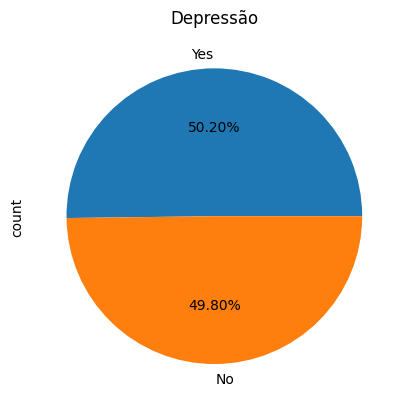

In [ ]:
depre["Depression"].value_counts().plot(kind='pie', autopct='%.2f%%', title='Depressão')

In [ ]:
numericas = ['Age', 'Academic Pressure', 'Study Satisfaction', 'Study Hours', 'Financial Stress']
categoricas = ['Gender', 'Sleep Duration', 'Dietary Habits', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

Gender
Male      267
Female    235
Name: count, dtype: int64


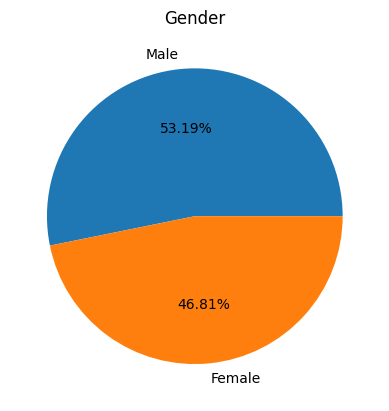


Sleep Duration
7-8 hours            128
More than 8 hours    128
5-6 hours            123
Less than 5 hours    123
Name: count, dtype: int64


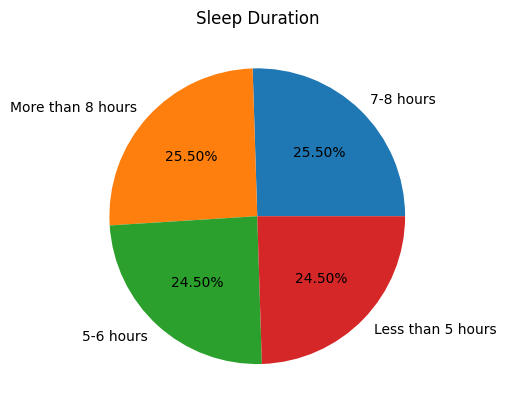


Dietary Habits
Moderate     172
Unhealthy    169
Healthy      161
Name: count, dtype: int64


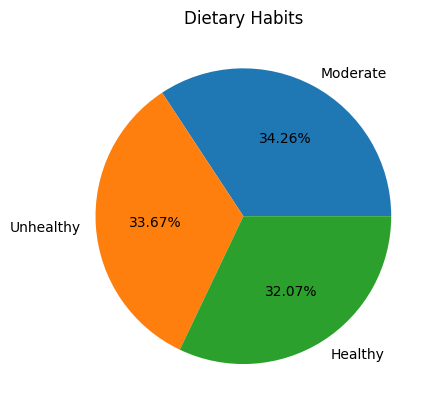


Have you ever had suicidal thoughts ?
Yes    260
No     242
Name: count, dtype: int64


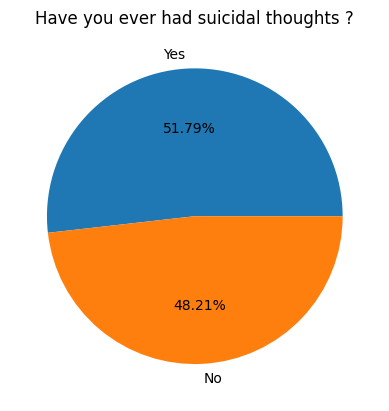


Family History of Mental Illness
No     265
Yes    237
Name: count, dtype: int64


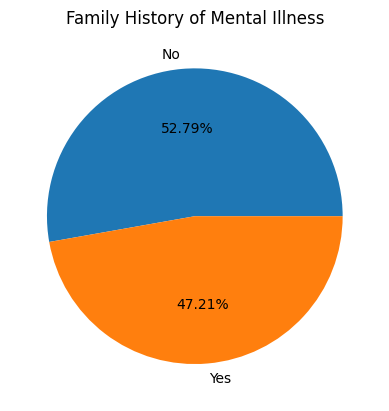

In [ ]:
# Verificação categóricas
for coluna in categoricas:
  print(depre[coluna].value_counts())
  plt.figure()
  depre[coluna].value_counts().plot(kind='pie', autopct='%.2f%%', title=coluna)
  plt.ylabel('')
  plt.show()
  print()

In [ ]:
# Verificação numéricas
print('Média')
for coluna in numericas:
  print(coluna + ':', depre[coluna].mean())

# Mediana
print('\nMediana')
for coluna in numericas:
  print(coluna + ':', depre[coluna].median())

# Moda
print('\nModa')
for coluna in numericas:
  print(coluna + ':', depre[coluna].mode())

# Variância
print('\nVariância')
for coluna in numericas:
  print(coluna + ':', depre[coluna].var())

# Desvio padrão
print('\nDesvio padrão')
for coluna in numericas:
  print(coluna + ':', depre[coluna].std())

# Quartis
print('\nQuartis')
for coluna in numericas:
  quartil = depre[coluna].quantile([0.25, 0.5, 0.75])
  print(quartil)
  q1 = quartil[0.25]
  q2 = quartil[0.5]
  q3 = quartil[0.75]
  print('Intervalo Interquartil:', q3 - q1)
  print('\n')

Média
Age: 26.241035856573706
Academic Pressure: 3.00398406374502
Study Satisfaction: 3.0756972111553784
Study Hours: 6.404382470119522
Financial Stress: 2.9282868525896415

Mediana
Age: 26.5
Academic Pressure: 3.0
Study Satisfaction: 3.0
Study Hours: 7.0
Financial Stress: 3.0

Moda
Age: 0    28
Name: Age, dtype: int64
Academic Pressure: 0    3.0
Name: Academic Pressure, dtype: float64
Study Satisfaction: 0    4.0
Name: Study Satisfaction, dtype: float64
Study Hours: 0    10
Name: Study Hours, dtype: int64
Financial Stress: 0    1
Name: Financial Stress, dtype: int64

Variância
Age: 23.97571788693526
Academic Pressure: 1.932119824096826
Study Satisfaction: 1.886474063824541
Study Hours: 14.005809098933625
Financial Stress: 2.0307751031800905

Desvio padrão
Age: 4.896500575608591
Academic Pressure: 1.3900071309517898
Study Satisfaction: 1.3734897392498209
Study Hours: 3.742433579762455
Financial Stress: 1.4250526668092272

Quartis
0.25    22.0
0.50    26.5
0.75    30.0
Name: Age, dtype:

In [ ]:
# Label-encoding nas features com Yes/No
depre['Depression'] = depre['Depression'].replace('No',0)
depre['Depression'] = depre['Depression'].replace('Yes',1)
depre['Have you ever had suicidal thoughts ?'] = depre['Have you ever had suicidal thoughts ?'].replace('No',0)
depre['Have you ever had suicidal thoughts ?'] = depre['Have you ever had suicidal thoughts ?'].replace('Yes',1)
depre['Family History of Mental Illness'] = depre['Family History of Mental Illness'].replace('No',0)
depre['Family History of Mental Illness'] = depre['Family History of Mental Illness'].replace('Yes',1)
depre.head()

,Gender,Age,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,28,2.0,4.0,7-8 hours,Moderate,1,9,2,1,0
1,Male,28,4.0,5.0,5-6 hours,Healthy,1,7,1,1,0
2,Male,25,1.0,3.0,5-6 hours,Unhealthy,1,10,4,0,1
3,Male,23,1.0,4.0,More than 8 hours,Unhealthy,1,7,2,1,0
4,Female,31,1.0,5.0,More than 8 hours,Healthy,1,4,2,1,0


In [ ]:
X = depre.drop('Depression', axis=1)
X = X.values
y = depre['Depression']

In [ ]:
# Imputação de dados faltantes aqui